[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y1/notebooks/euclidzoo_foundation_model.ipynb)

# Tiny Transfer Learning with Self-Supervised Encoders (DINOv2 vs Zoobot)

## Rodolphe Cledassou School 2025
> Marc Huertas-Company & Hubert Bretonnière

This notebook illustrates simple transfer learning for image classification:
1. **Self-supervised general encoder**: DINOv2-S (small) from Hugging Face — we freeze it and train a **linear probe** (logistic classifier) on your dataset.
2. **Domain-specific encoder**: **Zoobot** (ConvNeXt Nano) pretrained on galaxy images — we repeat the same linear-probe protocol.
3. **Compare** accuracy and confusion matrices.

> Why linear probe? It’s fast and isolates **feature quality** without conflating with heavy fine-tuning.

## 0) Setup & installs

- Installs: `transformers` (for DINOv2), `timm` (for Zoobot encoder), `datasets/torchvision` (data), `huggingface_hub` (model download).
- Device: prefer **Apple Metal (MPS)** on Mac; else CUDA; else CPU.

In [1]:
# If needed, uncomment these installs (run once)
# %pip install -q transformers timm datasets torchvision huggingface_hub Pillow

import os, math, random, time, numpy as np
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from datasets import load_dataset
from huggingface_hub import login

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

torch.manual_seed(42); np.random.seed(42); random.seed(42)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

Using device: mps


## 1) Data: use your local folder if available, else fall back to a tiny HF dataset

- If `./zoo-data/train/...` exists we load it as an ImageFolder.
- Otherwise, we use the **Beans** dataset (3 classes, small) from 🤗 Datasets to keep things light.
- We apply standard **224×224** transforms (to match ViT/ConvNeXt defaults).

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 64

from torchvision import transforms, datasets

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

def dl_from_imagefolder(root="zoo-data"):
    train_dir, test_dir = os.path.join(root,"train"), os.path.join(root,"test")
    if os.path.isdir(train_dir) and os.path.isdir(test_dir):
        train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
        test_ds  = datasets.ImageFolder(test_dir,  transform=test_tfms)
        return train_ds, test_ds
    return None, None

train_ds, test_ds = dl_from_imagefolder("zoo-data")


NUM_CLASSES = len(getattr(train_ds, "classes", [])) or len(set([y for _,y in [train_ds[i] for i in range(min(200,len(train_ds)))] ]))
print("Classes:", getattr(train_ds,"classes", f"{NUM_CLASSES} classes"))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Classes: ['featured', 'problem', 'smooth']


## 2) Linear probe on **DINOv2-S** (frozen) from Hugging Face

- Model: `facebook/dinov2-small`
- We use the CLS token from the final hidden state as a **feature vector**.
- We train a small **linear head** on top.
- Then we evaluate validation accuracy.

In [4]:
from transformers import AutoImageProcessor, AutoModel
import numpy as np




dinov2_id = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(dinov2_id)
encoder = AutoModel.from_pretrained(dinov2_id).to(device)
encoder.eval()
for p in encoder.parameters(): p.requires_grad = False

# infer hidden size
with torch.no_grad():
    dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    imgs = (dummy.permute(0,2,3,1).cpu().numpy()*255*0.5+127.5).clip(0,255).astype(np.uint8)
    inputs = processor(images=list(imgs), return_tensors="pt").to(device)
    out = encoder(**inputs)
    hidden_size = out.last_hidden_state.shape[-1]

head = nn.Linear(hidden_size, NUM_CLASSES).to(device)
optim = torch.optim.AdamW(head.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

def dinov2_features(batch_x):
    imgs = (batch_x.permute(0,2,3,1).cpu().numpy()*255*0.5+127.5).clip(0,255).astype(np.uint8)
    inputs = processor(images=list(imgs), return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = encoder(**inputs, output_attentions=False)
        feats = outputs.last_hidden_state[:, 0, :]
    return feats

def train_linear_probe(head, train_loader, steps=300):
    head.train()
    it = iter(train_loader)
    for step in range(1, steps+1):
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(train_loader); x, y = next(it)
        x, y = x.to(device), y.to(device)
        feats = dinov2_features(x)
        logits = head(feats)
        loss = criterion(logits, y)
        optim.zero_grad(set_to_none=True)
        loss.backward(); optim.step()
        if step % 50 == 0:
            pred = logits.argmax(1)
            acc = (pred==y).float().mean().item()
            print(f"[DINOv2] step {step:04d}  loss={loss.item():.4f}  acc(batch)={acc:.3f}")

@torch.no_grad()
def eval_linear_probe(head, loader):
    head.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        feats = dinov2_features(x)
        logits = head(feats)
        loss = criterion(logits, y)
        loss_sum += loss.item()*x.size(0)
        pred = logits.argmax(1)
        tot += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/tot, correct/tot

print("Training linear probe (DINOv2-S, frozen encoder)...")
train_linear_probe(head, train_loader, steps=300)
dino_val_loss, dino_val_acc = eval_linear_probe(head, val_loader)
print(f"[DINOv2] val loss={dino_val_loss:.4f}  acc={dino_val_acc:.4f}")

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Training linear probe (DINOv2-S, frozen encoder)...


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(
/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/

[DINOv2] step 0050  loss=0.5339  acc(batch)=0.719


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] step 0100  loss=0.4883  acc(batch)=0.750


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] step 0150  loss=0.6011  acc(batch)=0.797


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] step 0200  loss=0.5246  acc(batch)=0.797


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] step 0250  loss=0.3751  acc(batch)=0.891


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] step 0300  loss=0.2352  acc(batch)=0.938


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[DINOv2] val loss=0.4320  acc=0.8162


### 2.1) Attention map from DINOv2

Visualize CLS attention to patches (last layer, head 0) for one validation example.

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

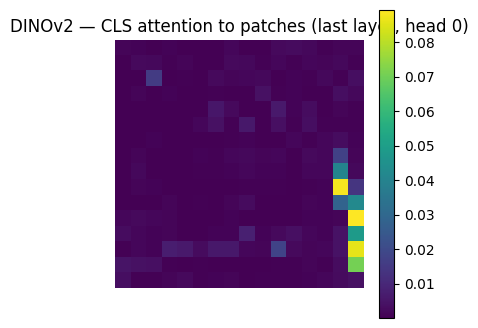

In [4]:
import matplotlib.pyplot as plt, math

@torch.no_grad()
def show_dinov2_attention(img_tensor):
    img = (img_tensor.permute(1,2,0).cpu().numpy()*255*0.5+127.5).clip(0,255).astype(np.uint8)
    inputs = processor(images=[img], return_tensors="pt").to(device)
    outputs = encoder(**inputs, output_attentions=True)
    att = outputs.attentions[-1][0, 0]  # [seq, seq]
    cls_to_patches = att[0].cpu().numpy()
    L = int(math.sqrt(cls_to_patches.shape[0]-1)) if (cls_to_patches.shape[0]-1)>0 else 1
    patch_map = cls_to_patches[1:].reshape(L, L)
    plt.figure(figsize=(4,4)); plt.imshow(patch_map)
    plt.title("DINOv2 — CLS attention to patches (last layer, head 0)"); plt.axis("off"); plt.colorbar(); plt.show()

xb, yb = next(iter(val_loader))
show_dinov2_attention(xb[0])

## 3) Linear probe on **Zoobot ConvNeXt Nano** (frozen)

In [3]:
import timm

zoobot_id = "mwalmsley/zoobot-encoder-convnext_nano"
encoder_zoobot = timm.create_model(f"hf_hub:{zoobot_id}", pretrained=True, num_classes=0).to(device)
encoder_zoobot.eval()
for p in encoder_zoobot.parameters(): p.requires_grad = False

with torch.no_grad():
    dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    feats = encoder_zoobot(dummy)
    feat_dim = feats.shape[-1] if feats.ndim == 2 else feats.flatten(1).shape[-1]

head_z = nn.Linear(feat_dim, NUM_CLASSES).to(device)
optim_z = torch.optim.AdamW(head_z.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

def zoobot_features(batch_x):
    with torch.no_grad():
        z = encoder_zoobot(batch_x)
        if z.ndim > 2: z = z.flatten(1)
    return z

def train_linear_probe_zoobot(head, train_loader, steps=300):
    head.train()
    it = iter(train_loader)
    for step in range(1, steps+1):
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(train_loader); x, y = next(it)
        x, y = x.to(device), y.to(device)
        feats = zoobot_features(x)
        logits = head(feats)
        loss = criterion(logits, y)
        optim_z.zero_grad(set_to_none=True)
        loss.backward(); optim_z.step()
        if step % 50 == 0:
            pred = logits.argmax(1)
            acc = (pred==y).float().mean().item()
            print(f"[Zoobot] step {step:04d}  loss={loss.item():.4f}  acc(batch)={acc:.3f}")

@torch.no_grad()
def eval_linear_probe_zoobot(head, loader):
    head.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        feats = zoobot_features(x)
        logits = head(feats)
        loss = criterion(logits, y)
        loss_sum += loss.item()*x.size(0)
        pred = logits.argmax(1)
        tot += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/tot, correct/tot

print("Training linear probe (Zoobot ConvNeXt Nano, frozen encoder)...")
train_linear_probe_zoobot(head_z, train_loader, steps=300)
zoobot_val_loss, zoobot_val_acc = eval_linear_probe_zoobot(head_z, val_loader)
print(f"[Zoobot] val loss={zoobot_val_loss:.4f}  acc={zoobot_val_acc:.4f}")

Training linear probe (Zoobot ConvNeXt Nano, frozen encoder)...


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0050  loss=0.3589  acc(batch)=0.859


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0100  loss=0.2292  acc(batch)=0.906


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0150  loss=0.3397  acc(batch)=0.844


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0200  loss=0.1776  acc(batch)=0.938


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0250  loss=0.3512  acc(batch)=0.859


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] step 0300  loss=0.2838  acc(batch)=0.891


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[Zoobot] val loss=0.2807  acc=0.8741


## 4) Compare results + confusion matrices

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

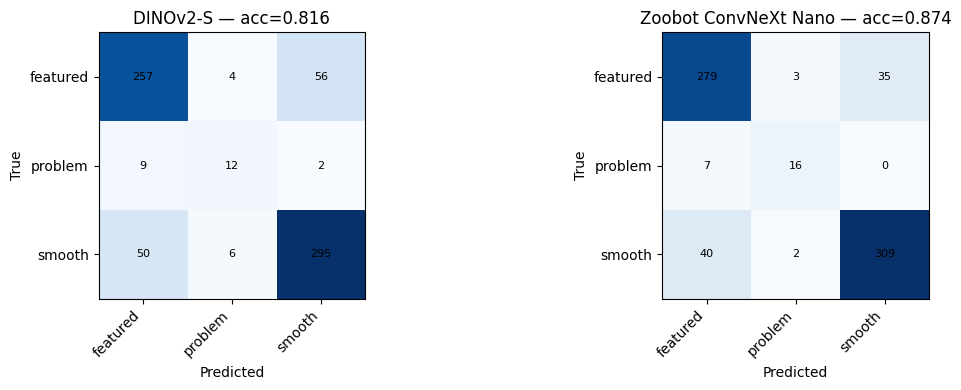

In [6]:
import numpy as np, matplotlib.pyplot as plt

@torch.no_grad()
def preds_for(head, loader, feats_fn):
    y_true, y_pred = [], []
    for x,y in loader:
        x = x.to(device)
        logits = head(feats_fn(x))
        y_true.append(y.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return y_true, y_pred

y_true_d, y_pred_d = preds_for(head,   val_loader, dinov2_features)
y_true_z, y_pred_z = preds_for(head_z, val_loader, zoobot_features)

labels = getattr(train_ds, "classes", [str(i) for i in range(int(max(y_true_d.max(), y_true_z.max()))+1)])
def confusion_matrix_np(y_true, y_pred, K):
    cm = np.zeros((K,K), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

cm_d = confusion_matrix_np(y_true_d, y_pred_d, len(labels))
cm_z = confusion_matrix_np(y_true_z, y_pred_z, len(labels))

def plot_cm(cm, labels, title, ax):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha="center", va="center", fontsize=8)
    return im

fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_cm(cm_d, labels, f"DINOv2-S — acc={dino_val_acc:.3f}", axes[0])
im = plot_cm(cm_z, labels, f"Zoobot ConvNeXt Nano — acc={zoobot_val_acc:.3f}", axes[1])
plt.tight_layout(); plt.show()